In [1]:
import xml.etree.ElementTree as ET
from nltk.tokenize import word_tokenize
import re
import string
from collections import Counter, defaultdict
from sklearn.metrics import f1_score
from seqlearn.hmm import MultinomialHMM
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/paperspace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/paperspace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
!ls ../UseCase_4_Datasets

Laptops_Test_Gold.xml  Laptops_Train_v2.xml


# Aspect Tag Extraction

In aspect tag extraction, users are interested in extracting the top-N terms from text written about their products, such as product reviews, to understand what their consumers are talking about and how they feel about it.

For aspect tag extracting, it would be useful to have a classifier to determine whether words in a text are aspect terms are not. Then the predicted aspected terms can be counted and the top-N terms extracted.

# Data Preparation

The data for aspect tagging is contained in xml files with children nodes containing sentences and a list of aspect terms, if any exist. In this notebook, 3 different models will be considered for aspect term classification and each model requires data in a different format and so it would be useful to have a data manager that can read the data and process it into a format that can be fed into each model.

A look through the data revealed that there is some noise, with words being classified inconsistently between samples. For example, CDs/DVDs could be classified as two separate aspect terms, CDs and DVDs or as a single aspect term CDs/DVDs. There are many cases where words are treated inconsistently with special characters, and so it is important to ensure that words can be tagged accurately to train a classifier. However, hand-checking each sample is expensive and infeasible and so automatic preprocessing should be done to ensure that there is a certain level of data coverage and that words are tagged with error under a certain threshold.

In [65]:
class DataManager:
    '''Data managing class for reading and cleaning data for modeling.
    
    Parameters:
        idir: input directory for data files
    
    Methods:
        get_data_for_naive: lower (boolean)
            Returns: X_train, y_train, X_test, y_test
                Lists of word and tags. Each word in X corresponds to a tag in y.
                If lower if set to True, words and tags are returned in lowercase.
                
        get_data_for_hmm: lower (boolean)
            Returns: X_train, y_train, X_test, y_test
                Arrays of one-hot vector encoding of words and 1-d tag array.
                Each item in the array is a list of one-hot encoding vectors that altogether represent a sentence.
                Each sentence has a corresponding 1-d vector for its tag labels. If lower is set to True, words and 
                tags are lowercased before they are encoded.
        
        get_data_for_crf:
            Returns: X_train, y_train, X_test, y_test
                Array of paired list of feature vectors and their corresponding tag vectors.
                Each item in the array is a list of feature vectors generated for each word in a sentence.
        
        get_aspect_terms:
            Returns: aspect_train, aspect_test
                List of nested aspect terms present in the training and test data.
                Aspect terms are returned as nested lists so that they can be indexed for cross-validation. A list of
                aspect terms is returned for each sentence in the data, including empty lists in cases where there are
                no aspect terms.
    '''
    
    def __init__(self, idir):
        self.train_file = idir + "Laptops_Train_v2.xml"
        self.test_file = idir + "Laptops_Test_Gold.xml"
    #    self.stopwords = set(stopwords.words("english"))
        
    def _read_data(self):
        '''Reads through training and test xml files and finds corresponding sentences and list of aspect terms.'''
        def parse_sentence(sentence):
            #sentence_id = sentence.attrib["id"]
            text = sentence.find("text").text
            
            aspect_terms = sentence.find("aspectTerms")
            aspect_terms = [x.attrib["term"] for x in aspect_terms] if aspect_terms is not None else []
            
            return text, aspect_terms
        
        train_data = [parse_sentence(s) for s in ET.parse(self.train_file).getroot().findall("sentence")]
        test_data = [parse_sentence(s) for s in ET.parse(self.test_file).getroot().findall("sentence")]
            
        return train_data, test_data
    
    def _flatten_2d_list(self, l):
        '''Helper function for flattening 2-d lists'''
        return [item for sublist in l for item in sublist]
    
    def _get_words_from_words_tags_pairs(self, words_tags_pairs):
        '''Retrieves the words from a nested list of word and tag pairs.'''
        word_tag_pairs = self._flatten_2d_list(words_tags_pairs)
        words = [x[0] for x in word_tag_pairs]
        return words
    
    def get_data_for_naive(self, lower=False):
        train, test = self._get_word_tag_pairs(lower=lower)
        train, test = self._flatten_2d_list(train), self._flatten_2d_list(test)
        
        X_train, y_train = zip(*train)
        X_test, y_test = zip(*test)
        return X_train, y_train, X_test, y_test
    
    def get_data_for_hmm(self, lower=False):
        '''Method for retrieving data for hidden markov models.
        
        Feature vectors must be one-hot encoded and so words not present in the training set are replaced
        with an <unk> token.
        '''
        def replace_unknowns(word_tag_pairs, word_bank):
            '''Replace words not present in a preset list with an unknown token for one-hot encoding.'''
            return [(x[0], x[1]) if x[0] in word_bank else ("<unk>", x[1]) for x in word_tag_pairs]
        
        def replace_words_with_ids(word_tag_pairs, word_bank):
            return [(word_bank[x[0]], x[1]) for x in word_tag_pairs]
        
        def onehot_encode(id_tag_pairs, n_labels):
            X, y = zip(*id_tag_pairs)
            n_samples = len(X)
            X_matrix = np.zeros((n_samples, n_labels))
            X_matrix[np.arange(n_samples), X] = 1
            
            return X_matrix, np.array(y)
        
        train, test = self._get_word_tag_pairs(lower=lower)
        
        train_sentence_lens, test_sentence_lens = [len(x) for x in train], [len(x) for x in test]
        
        self._init_word_bank(self._get_words_from_words_tags_pairs(train))
        test = [replace_unknowns(x, self.word_bank) for x in test]
        
        train = [replace_words_with_ids(x, self.word_bank) for x in train]
        test = [replace_words_with_ids(x, self.word_bank) for x in test]

        n_labels = len(self.word_bank)
        X_train, y_train = zip(*(onehot_encode(x, n_labels) for x in train))
        X_test, y_test = zip(*(onehot_encode(x, n_labels) for x in test))
        
        return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    def get_data_for_crf(self):
        def generate_features(sentences):
            '''Feature generation function.
            
            Input: list of sentences.
            Returns: nested list of feature vectors.
                A feature vector is generated for each word in each sentence.
            '''
            def get_tfidf_score(tfidf_matrix, idx, word):
                '''Looks up tf-idf scores for specified sentence in the current corpus.'''
                feature_idx = tfidf_matrix[idx,:].nonzero()[1]
                tfidf_scores = zip(feature_idx, [tfidf_matrix[idx,x] for x in feature_idx])
                feature_names = tfidf.get_feature_names()
                score_dict = defaultdict(lambda: 0.0)
                for w,s in [(feature_names[i], s) for (i,s) in tfidf_scores]:
                    score_dict[w] = s
                return score_dict
            
            st = LancasterStemmer()
            
        #    tfidf = TfidfVectorizer(ngram_range=(1,1), min_df=5)
        #    tfidf_matrix = tfidf.fit_transform([" ".join(s) for s in sentences])
            
            features = []
            for sentence_idx, s in enumerate(sentences):
                feature_set = [[] for x in range(len(s))]
                pos_tags = nltk.pos_tag(s)
                stems = [st.stem(word) for word in s]
                stem_pos = nltk.pos_tag(stems)
        #        tfidf_scores = get_tfidf_score(tfidf_matrix, sentence_idx, s)
                
                for idx in range(len(feature_set)):
                    word_lower = s[idx].lower()
                    feature_set[idx].append("bias")
                    feature_set[idx].append("word_lower=" + word_lower)
                    feature_set[idx].append("pos_tag=" + pos_tags[idx][1])
                    feature_set[idx].append("is_noun={0:d}".format("NN" in pos_tags[idx][1]))
                    feature_set[idx].append("is_adj={0:d}".format("JJ" in pos_tags[idx][1]))
                    feature_set[idx].append("is_verb={0:d}".format("VB" in pos_tags[idx][1]))
                    feature_set[idx].append("stem=" + stems[idx])
                    feature_set[idx].append("stem_pos=" + stem_pos[idx][1])
        #            feature_set[idx].append({"tfidf":tfidf_scores[word_lower]})
                    
                    if idx > 0:
                        feature_set[idx].append("-1:word_lower=" + s[idx-1].lower())
                        feature_set[idx].append("-1:pos_tag=" + pos_tags[idx-1][1])
                        feature_set[idx].append("-1:is_comma={0:d}".format(s[idx-1].lower() == ","))
                        feature_set[idx].append("-1:is_noun={0:d}".format("NN" in pos_tags[idx-1][1]))
                        feature_set[idx].append("-1:is_adj={0:d}".format("JJ" in pos_tags[idx-1][1]))
                        feature_set[idx].append("-1:is_verb={0:d}".format("VB" in pos_tags[idx-1][1]))
                        feature_set[idx].append("-1:stem=" + stems[idx-1])
                        feature_set[idx].append("-1:stem_pos=" + stem_pos[idx-1][1])
                                             
                    if idx > 1:
                        feature_set[idx].append("-2:word_lower=" + s[idx-2].lower())
                        feature_set[idx].append("-2:pos_tag=" + pos_tags[idx-2][1])
                        feature_set[idx].append("-2:is_comma={0:d}".format(s[idx-2].lower() == ","))
                        feature_set[idx].append("-2:is_noun={0:d}".format("NN" in pos_tags[idx-2][1]))
                        feature_set[idx].append("-2:is_adj={0:d}".format("JJ" in pos_tags[idx-2][1]))
                        feature_set[idx].append("-2:is_verb={0:d}".format("VB" in pos_tags[idx-2][1]))
                        feature_set[idx].append("-2:stem=" + stems[idx-2])
                        feature_set[idx].append("-2:stem_pos=" + stem_pos[idx-2][1])
                        
                    if idx < len(s) - 1:
                        feature_set[idx].append("+1:word_lower=" + s[idx+1].lower())
                        feature_set[idx].append("+1:pos_tag=" + pos_tags[idx+1][1])
                        feature_set[idx].append("+1:is_comma={0:d}".format(s[idx+1].lower() == ","))
                        feature_set[idx].append("+1:is_noun={0:d}".format("NN" in pos_tags[idx+1][1]))
                        feature_set[idx].append("+1:is_adj={0:d}".format("JJ" in pos_tags[idx+1][1]))
                        feature_set[idx].append("+1:is_verb={0:d}".format("VB" in pos_tags[idx+1][1]))
                        feature_set[idx].append("+1:stem=" + stems[idx+1])
                        feature_set[idx].append("+1:stem_pos=" + stem_pos[idx+1][1])
                   
                features.append(feature_set)
            
            return features
        
        def unpack_data(sent_tag_pairs):
            '''Unpacks sentence and tag pairs into separate lists of sentences and tags.
            
            Each item in X is a list corresponding to a sentence. Each item in y is a list of aspect tags.
            '''
            X, y = [], []
            for pair in sent_tag_pairs:
                xseq, yseq = zip(*pair)
                X.append(xseq)
                y.append(yseq)
                
            return X, y
        
        train, test = self._get_word_tag_pairs(lower=False)
        X_train, y_train = unpack_data(train)
        X_test, y_test = unpack_data(test)
        
        X_train = generate_features(X_train)
        X_test = generate_features(X_test)
        
        return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
    
    def _get_word_tag_pairs(self, lower=False):
        '''Helper function that returns word and BIO-tag pairs.
        
        Parameters: 
            lower: boolean
                Whether or not to lowercase the words as they are preprocessed for BIO-tagging.
            
        Returns: train_data, test_data
            List of lists of word and BIO tag pairs.
            
        Checks that after BIO tagging, the number of mistagged samples does not exceed a preset threshold.
        '''
        def vector_pair_to_word_pairs(x):
            '''Converts a vector of words and tags to list of word and tag pairs.'''
            return [list(zip(sentence, tags)) for sentence, tags in x]
                
        train, test = self._read_data()
 
        self.num_mistagged = 0
        self.mistagged = []
        bio_tagged_train = [self._bio_tag(*x, lower=lower) for x in train]
        bio_tagged_test = [self._bio_tag(*x, lower=lower) for x in test]
        
        bio_tagged_train = [x for x in bio_tagged_train if x is not None]
        bio_tagged_test = [x for x in bio_tagged_test if x is not None]
        
        assert self.num_mistagged < 30, "Too many mistagged samples ({}); check tagging process.".format(self.num_mistagged)
        
        word_tag_pairs_train = vector_pair_to_word_pairs(bio_tagged_train)
        word_tag_pairs_test = vector_pair_to_word_pairs(bio_tagged_test)
        
        return word_tag_pairs_train, word_tag_pairs_test
    
    def _init_word_bank(self, words):
        '''Initializes a word-to-index bank out of a list of words'''
        self.word_bank = {word:idx for idx,word in enumerate(set(words),1)}
        self.word_bank["<unk>"] = 0
            
    def _preprocess_str(self, s, lower=False):
        '''String preprocessing to help with word tokenizing.'''
        replace_with_space = re.compile(r'[:]')
        replace_with_empty = re.compile(r'[^\w\s\d\,]')
        s = re.sub(replace_with_space, ' ', s)
        s = re.sub(replace_with_empty, '', s)
        if lower:
            s = s.lower()
        return s
            
    def _bio_tag(self, sentence, tags, lower, drop_mistagged=True):
        '''Helper function that tags sentences with BIO tags.
        
        Parameters:
            sentence: a single sentence
            tags: list of aspect terms
            lower: boolean
                If True, lowercase words in sentence and tags.
            drop_mistagged: boolean
                If True, mistagged sentences are not returned as part of the dataset.
                
        Returns: words, bio_tags
            List of words and list of corresponding bio tags.
    
        Greedily tag phrases in the sentence by tagging from the longest aspect terms first. Since the 
        word may appear in multiple aspect tag phrases, it is important to do this greedily to ensure
        that words are not mistakenly tagged by shorter aspect tag phrases. For example, if a sentence
        contains aspect terms, 'battery' and 'battery life', it is important that the battery in 'battery
        life' is not mistakening tagged as the 'battery' term and 'battery life' is then left untaggable.
    
        When BIO-tagging, strings are preprocessed to remove special symbols and tokenized with 
        NLTK for better delimiter functionality. After BIO-tagging, check that there are the correct
        number of B and aspect-term related tags. Mistagged sentences are counted to ensure that the mistagged
        sentences do not exceed a threshold.
        '''
        #sentence_words = _preprocess_str(sentence).split()
        sentence_words = word_tokenize(self._preprocess_str(sentence, lower))
        num_sentence_words = len(sentence_words)
        bio_vec = ['O']*num_sentence_words
        
        for t in sorted(tags, key=lambda x: len(x.split()), reverse=True):
            tag_words = [self._preprocess_str(x, lower) for x in t.split()]
            num_tag_words = len(tag_words)

            for offset in range(num_sentence_words - num_tag_words + 1):
                if tag_words == sentence_words[offset:offset+num_tag_words] and bio_vec[offset] == 'O':
                    bio_vec[offset] = 'B'
                    if num_tag_words > 1:
                        bio_vec[offset+1:offset+num_tag_words] = ['I']*(num_tag_words-1)
                    break
        
        if len(tags) != sum(x == 'B' for x in bio_vec) or sum(len(x.split()) for x in tags) != sum(x != 'O' for x in bio_vec):
            self.num_mistagged += 1
            self.mistagged.append((sentence, sentence_words, tags, bio_vec))
            if drop_mistagged:
                return None
            
        return sentence_words, bio_vec
    
    def get_aspect_terms(self, lower=True):
        def extract_aspect_terms(sentence_aspect_pair):
            '''Returns just the aspect terms from a sentence and aspect term pair.'''
            aspect_terms = [x[1] for x in sentence_aspect_pair]
            out = []
            for aspect_list in aspect_terms:
                out.append([self._preprocess_str(word, lower=lower) for word in aspect_list])
                
            return out
        
        train, test = self._read_data()
        
        aspect_train = extract_aspect_terms(train)
        aspect_test = extract_aspect_terms(test)
        
        return aspect_train, aspect_test

# Check data distribution

In [66]:
dm = DataManager("../UseCase_4_Datasets/")

train, test = dm._get_word_tag_pairs()
words_train =set(x[0][0].lower() for x in train)
words_test = [x[0][0].lower() for x in test]
print("Number of words in test data that do not appear in training:",len([x for x in words_test if x not in words_train]),"\n")
print("Words not in training data:", [x for x in words_test if x not in words_train])

aspect_train, aspect_test = dm.get_aspect_terms()
aspect_train = set([item for sublist in aspect_train for item in sublist])
aspect_test = [item for sublist in aspect_test for item in sublist]
num_new_aspects = len([x for x in aspect_test if x not in aspect_train])
print("\nNumber of aspect terms in test data that do not appear in training:", num_new_aspects)
print("\nPercent of aspect terms that are new: %.3f%%" % (num_new_aspects / (len(aspect_train)+len(aspect_test)) * 100))

Number of words in test data that do not appear in training: 80 

Words not in training data: ['boot', 'set', 'works', 'made', 'lastly', 'biggest', 'out', 'out', 'ms', 'incredible', 'builtin', 'cons', 'hes', 'nothing', 'set', 'btw', 'huge', 'looked', 'nothing', 'deal', 'minis', 'cheaper', 'extremely', 'turns', 'starts', 'quick', 'havent', 'harddrive', 'nice', 'usb3', '99900', 'excelent', 'considering', 'stop', 'osx', 'trashed', 'shipped', 'user', 'performance', 'buying', 'moving', 'searched', 'nothing', 'logic', 'osx', '3d', '1244', 'put', 'why', 'their', 'perfectthanks', 'bootup', 'wifi', 'soft', 'wow', 'customization', 'far', 'cons', '1010', 'words', 'nice', 'replaced', 'premium', 'shipping', 'additionally', 'chatting', 'user', 'solution', 'fits', 'put', 'wasnt', 'quietest', 'air', 'working', 'further', 'fine', 'ideal', 'added', 'packing', 'cost']

Number of aspect terms in test data that do not appear in training: 272

Percent of aspect terms that are new: 16.947%


In [6]:
Counter(dict(zip(*np.unique([x[1] for x in nltk.pos_tag(aspect_train)], return_counts=True)))).most_common()

[('NN', 436),
 ('JJ', 157),
 ('NNS', 124),
 ('VBP', 78),
 ('VBG', 35),
 ('CD', 30),
 ('VBZ', 22),
 ('RB', 19),
 ('VBD', 18),
 ('VBN', 8),
 ('IN', 7),
 ('VB', 4),
 ('NNP', 3),
 ('CC', 2),
 ('DT', 2),
 ('FW', 2),
 ('RBR', 2),
 ('$', 1),
 ('JJR', 1)]

Most aspect terms are nouns, with some adjectives and fewer verbs.

In [7]:
X_train, y_train, X_test, _ = dm.get_data_for_hmm()
print("Percent of mistagged sentences: %.3f%%" % (dm.num_mistagged/(len(X_train) + len(X_test))))

print("\nAspect tag distribution:")
for i, j in zip(*np.unique(np.hstack(y_train), return_counts=True)):
    print(i, j)
    
tag_distribution = dict(zip(*np.unique(np.hstack(y_train), return_counts=True)))
print("\nPercent of positive classes: %.3f%%" % ((tag_distribution["B"] + tag_distribution["I"]) / np.sum(list(tag_distribution.values())) * 100))

Percent of mistagged sentences: 0.005%

Aspect tag distribution:
B 2317
I 1122
O 43085

Percent of positive classes: 7.392%


We can see that there are a few words and quite a few aspect terms that appear in the test data but not in the training data. It will be important to learn relations in the modeling to predict new aspect terms. 

The target classes are also heavily imbalanced so metrics like precision, recall, and f1-score should be considered over accuracy.

# Naive Modeling

When predictive modeling, it is useful to establish a naive baseline from naive forecasts. Naive forecasts are computationally cheap and easy to implement. If a model is unable to outperform the naive baseline, it may not be worth pursuing as time and resources are limited.

In the case of aspect tagging, naive tag predictions can be calculated by counting the number of times each tag occurs for each word in the training data. When making predictions, simply predict the class that occured most often.

In [8]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import precision_score, recall_score

In [9]:
class NaiveTagger(BaseEstimator, ClassifierMixin):
    '''Naive tagging model.
    
    attributes:
        most_frequent: dictionary keeping track of the most likely tag based on tag occurrence.
    
    methods:
        fit: Takes a list of words and a list of corresponding tags as input. Counts the number of times each tag
            occurs for each word and updates most_frequent with the word and its most frequently occuring tag.
        
        predict: Given a list of words, return a list of tags. If a word does not occur in the training data, 
            return 'O' which is the most frequent tag in the data.
    '''
    def __init__(self):
        self.most_frequent = {}
    
    def fit(self, X, y):
        class_counts = defaultdict(Counter)
        for word, tag in zip(X, y):
            class_counts[word].update(tag)
        
        self.most_frequent = {k:v.most_common(1)[0][0] for k, v in class_counts.items()}
    
    def predict(self, X):
        return [self.most_frequent[x] if x in self.most_frequent else 'O' for x in X]
    
def accuracy(obs, predict):
    assert len(obs) == len(predict), "Number of observed samples does not match number of predicted samples."
    return sum(x == y for x, y in zip(obs,predict))/len(obs)

def calc_score_summary(obs, predict):
    '''Returns a dict containing precision, recall, and f1 score.'''
    scores = {}
    scores["precision"] = precision_score(obs, predict, average="macro")
    scores["recall"] = recall_score(obs, predict, average="macro")
    scores["f1"] = f1_score(obs, predict, average="macro")
    
    return scores

In [10]:
naive_tagger = NaiveTagger()

X_train, y_train, _, _ = dm.get_data_for_naive(lower=True)
cv_scores = cross_validate(naive_tagger, X_train, y_train, scoring=["precision_macro","recall_macro","accuracy", "f1_macro"], cv=5, return_train_score=False)
print("f1 cv score: %.3f" % cv_scores["test_f1_macro"].mean())
print("precision cv score: %.3f" % cv_scores["test_precision_macro"].mean())
print("recall cv score: %.3f" % cv_scores["test_recall_macro"].mean())

f1 cv score: 0.707
precision cv score: 0.758
recall cv score: 0.674


# Hidden Markov Model

Hidden markov models are a form of generative model commonly used in sequence modeling that work under the belief that there are latent states that lead to observations. 

\begin{equation*}
P(Y) = \sum_{X}P(Y|X)P(X)
\end{equation*}

From our word observations, we can calculate the most likely sequence of states that led to the observed word sequences. In this case, the most likely sequence of BIO tags. The shortcoming here is that hidden markov models only consider the state at the previous time step, but in sequence tagging it can be useful to consider words at other time steps as well as bidirectionally.

In [11]:
kf = KFold(n_splits=5)
X_train, y_train, _, _ = dm.get_data_for_hmm(lower=True)

best_alpha = None
best_f1 = None
best_cv_scores = None
for alpha in np.linspace(0.0001,.1,5):
    hmm = MultinomialHMM(decode="viterbi", alpha=alpha)

    cv_scores = {
        "precision" : [],
        "recall" : [],
        "f1" : []
    }
    for train_idx, val_idx in kf.split(X_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        sentence_len_train = [len(x) for x in X_t]
        sentence_len_val = [len(x) for x in X_v]

        X_t, X_v = np.vstack(X_t), np.vstack(X_v)
        y_t, y_v = np.hstack(y_t), np.hstack(y_v)
        hmm.fit(X_t, y_t, sentence_len_train)
        scores = calc_score_summary(y_v, hmm.predict(X_v, sentence_len_val))
        cv_scores["precision"].append(scores["precision"])
        cv_scores["recall"].append(scores["recall"])
        cv_scores["f1"].append(scores["f1"])

    new_f1 = np.mean(cv_scores["f1"])
    print("f1-cv-score (alpha: {:.4f}): {:.3f}".format(alpha, new_f1))
    if best_f1 is None or new_f1 > best_f1:
        best_alpha = alpha
        best_f1 = new_f1
        best_cv_scores = cv_scores

f1-cv-score (alpha: 0.0001): 0.620
f1-cv-score (alpha: 0.0251): 0.612
f1-cv-score (alpha: 0.0501): 0.600
f1-cv-score (alpha: 0.0750): 0.595
f1-cv-score (alpha: 0.1000): 0.586


In [12]:
print("precision cv score:", np.mean(best_cv_scores["precision"]))
print("recall cv score:", np.mean(best_cv_scores["recall"]))
print("f1 cv score:", np.mean(best_cv_scores["f1"]))

precision cv score: 0.8856304975552952
recall cv score: 0.5419550605536116
f1 cv score: 0.6201704677176185


We can see that HMM fails to meet the baseline set by naive tagging and so let's move onto a more flexible model.

# Conditional Random Fields

Conditional random fields are basically the logistic regression of sequence tagging. Each word has a feature vector and weights that determine the word's class label. The feature vector is multiplied by the weights and then normalized into class label probabilities.

By analyzing the weights, it is possible to see which states and transitions generally lead to which class labels.

In [13]:
import pycrfsuite
import errno
import os

In [14]:
class CRFModel(BaseEstimator, ClassifierMixin):
    '''Wrapper for pycrfsuite
    
    parameters:
        model_path: str
            filepath for saving and loading the model.
        c2: float
            l2 regularization coefficient
        max_iterations: int
            max number of iterations to train for
        possible_transitions: boolean
            Whether or not to include all possible transitions in the model graph, even transitions not observed in the training data.
            May help the model generalize better to unseen samples.
        verbose: boolean
            Print crfsuite output.
        
    methods:
        fit: Takes a nested list of sentence and tag pairs and fits the model.
        predict: Generates predictions for a nested list of sentences.
        print_feature_summary: Print 
    
    A CRF model consists of a trainer and a tagger.
    '''
    def __init__(self, model_path, c1=0, c2=1, max_iterations=1000, possible_transitions=False, verbose=False):
        self.trainer = pycrfsuite.Trainer(verbose=verbose)
        self.tagger = pycrfsuite.Tagger()
        self.model_path = model_path
        
        self.trainer.set_params({
            "feature.possible_transitions": possible_transitions,
            "c1": c1,
            "c2": c2,
            "max_iterations": max_iterations,
        })
    
    def fit(self, X, y):
        for x, y in zip(X, y):
            self.trainer.append(x, y)
            
        self.trainer.train(self.model_path)
    
    def predict(self, X):
        try:
            self.tagger.open(self.model_path)
        except:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), self.model_path)
            
        y_pred = [self.tagger.tag(x) for x in X]
        return y_pred
    
    def print_feature_summary(self, n=10):
        def print_states(info, n):
            print("State transitions:")
            state_transitions = Counter(info.transitions)
            state_features = state_transitions.most_common(n)
            for (label_from, label_to), weight in state_features:
                print("%-6s -> %-7s %0.3f" % (label_from, label_to, weight))
                
        def print_transitions(info, n):
            transitions = Counter(info.state_features)
            print("Top {} transitions".format(n))
            print(transitions.most_common(n))
            print("Bottom {} transitions".format(n))
            print(transitions.most_common()[-n:])
            
        info = self.tagger.info()
        print_states(info, n)
        print_transitions(info, n)

In [15]:
def unpacked_f1_score(y_true, y_pred, average="macro"):
    '''Flattened version of f1-score.'''
    y_true = [l for sublist in y_true for l in sublist]
    y_pred = [l for sublist in y_pred for l in sublist]
    
    return f1_score(y_true, y_pred, average=average)

def unpacked_precision_score(y_true, y_pred, average="macro"):
    '''Flattened version of precision score.'''
    y_true = [l for sublist in y_true for l in sublist]
    y_pred = [l for sublist in y_pred for l in sublist]
    
    return precision_score(y_true, y_pred, average=average)

def unpacked_recall_score(y_true, y_pred, average="macro"):
    '''Flattened version of recall score.'''
    y_true = [l for sublist in y_true for l in sublist]
    y_pred = [l for sublist in y_pred for l in sublist]
    
    return recall_score(y_true, y_pred, average=average)

In [67]:
X_train, y_train, X_test, y_test = dm.get_data_for_crf()

In [17]:
kf = KFold(n_splits=5)

potential_c2 = np.linspace(0.08,.13,5)
potential_c1 = [.25]
best_c2 = None
best_c1 = None
best_f1 = None
for c2 in potential_c2:
    for c1 in potential_c1:
        print("Trying c2:", c2, "c1:", c1)
        cv_scores = {
            "precision" : [],
            "recall" : [],
            "f1" : []
        }

        for train_idx, val_idx in kf.split(X_train):
            crf = CRFModel("crf_baseline.model", max_iterations=500, possible_transitions=True, c1=c1, c2=c2, verbose=False)
            X_t, X_v = X_train[train_idx], X_train[val_idx]
            y_t, y_v = y_train[train_idx], y_train[val_idx]

            crf.fit(X_t, y_t)
            crf_predict = crf.predict(X_v)
            cv_scores["precision"].append(unpacked_precision_score(y_v, crf_predict))
            cv_scores["recall"].append(unpacked_recall_score(y_v, crf_predict))
            cv_scores["f1"].append(unpacked_f1_score(y_v, crf_predict))

        avg_cv_f1 = np.mean(cv_scores["f1"])
        if best_f1 is None or avg_cv_f1 > best_f1:
            best_c2 = c2
            best_c1 = c1
            best_f1 = avg_cv_f1
            print("Updating c2 to {} with f1 of {}".format(best_c2, best_f1))
            print("Updating c1 to {} with f1 of {}".format(best_c1, best_f1))

Trying c2: 0.08 c1: 0.25
Updating c2 to 0.08 with f1 of 0.8182880657754499
Updating c1 to 0.25 with f1 of 0.8182880657754499
Trying c2: 0.0925 c1: 0.25
Updating c2 to 0.0925 with f1 of 0.8184505206624703
Updating c1 to 0.25 with f1 of 0.8184505206624703
Trying c2: 0.10500000000000001 c1: 0.25
Trying c2: 0.11750000000000001 c1: 0.25
Trying c2: 0.13 c1: 0.25


In [68]:
kf = KFold(n_splits=5)

cv_scores = {
    "precision" : [],
    "recall" : [],
    "f1" : []
}

for train_idx, val_idx in kf.split(X_train):
    crf = CRFModel("crf_baseline.model", c1=0.25, c2=0.011, max_iterations=500, possible_transitions=True, verbose=False)
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]

    crf.fit(X_t, y_t)
    crf_predict = crf.predict(X_v)
    cv_scores["precision"].append(unpacked_precision_score(y_v, crf_predict))
    cv_scores["recall"].append(unpacked_recall_score(y_v, crf_predict))
    cv_scores["f1"].append(unpacked_f1_score(y_v, crf_predict))
    

In [39]:
print("precision cv score:", np.mean(cv_scores["precision"]))
print("recall cv score:", np.mean(cv_scores["recall"]))
print("f1 cv score:", np.mean(cv_scores["f1"]))

precision cv score: 0.8605484627946967
recall cv score: 0.7884367867120677
f1 cv score: 0.8205732056583674


L1 regularization ended up negatively impacting the CV score of the aspect term extractor, and so is dropped from the final model.

In [70]:
crf = CRFModel("crf_baseline.model", c2=0.011, possible_transitions=True, verbose=False)
crf.fit(X_train, y_train)

y_pred = crf.predict(X_test)

In [71]:
crf.print_feature_summary(10)

State transitions:
B      -> I       5.223
O      -> B       4.351
I      -> I       4.239
O      -> O       3.651
B      -> O       -1.567
I      -> B       -1.674
I      -> O       -2.202
B      -> B       -3.213
O      -> I       -8.807
Top 10 transitions
[(('stem=feat', 'B'), 8.300384), (('word_lower=wt', 'B'), 6.342375), (('stem=wt', 'B'), 6.342375), (('word_lower=software', 'B'), 6.296352), (('stem=softw', 'B'), 6.296352), (('stem=apply', 'B'), 5.956188), (('stem=iphoto', 'B'), 5.711429), (('stem=motherboard', 'B'), 5.591451), (('stem=feat', 'I'), 5.447068), (('word_lower=ilife', 'B'), 5.302806)]
Bottom 10 transitions
[(('stem=mem', 'O'), -4.011126), (('stem=warranty', 'O'), -4.012371), (('stem=charg', 'O'), -4.014683), (('stem=program', 'O'), -4.163778), (('stem=serv', 'O'), -4.220647), (('stem=key', 'O'), -4.235145), (('stem=perform', 'O'), -4.277455), (('stem=battery', 'O'), -4.677513), (('stem=driv', 'O'), -5.378339), (('stem=pric', 'O'), -5.380914)]


In [42]:
print(unpacked_f1_score(y_test, y_pred, average="macro"))

0.7947651906606245


# Aspect term extracting

Now that we have a classifier, we can extract aspect terms from a corpus. 

How should aspect term extraction be evaluated? It might seem intuitive to use precision, recall, and f1-score.

However, since users only care about the top N aspect terms, aspect terms that rank high in importance should be given more weight than aspect terms that are not that common. So, a weighted form of precision and recall should be used. (Pavlopoulos and Androutsopoulos, 2017)

In [72]:
class AspectTermExtractor:
    '''Model for extracting aspect terms.
    
    parameters:
        model_path: str
            Filepath for loading and saving model.
        mode: str
            Mode for model to use for aspect term extraction. Currently only supports CRF.
        c1: float
            l1 regularization term for CRF.
        c2: float
            l2 regularization term for CRF.
        possible_transitions: boolean
            Include all possible transitions for CRF model.
            
    methods:
        get_top_n(n):
            Returns top n aspect terms.
        evaluate(X, y, n):
            X: Input matrix for prediction. Check model implementation for details.
            y: True aspect term list.
            n: Number of top aspect terms to evaluate on, based on weighted precision and recall.
    '''
    def __init__(self, model_path=None, mode="crf", max_iterations=1000, c1=0.0, c2=1.0, possible_transitions=False):
        assert mode in ["crf"], "Invalid model type. Valid modes are: [crf]."
        self.model_path = model_path
        self.mode = mode
        self.c1 = c1
        self.c2 = c2
        self.possible_transitions = possible_transitions
        self.max_iterations = max_iterations
        
    def fit(self, X, y):
        if self.mode == "crf":
            self.model = CRFModel(self.model_path, c1=self.c1, c2=self.c2, max_iterations=self.max_iterations, 
                                  possible_transitions=self.possible_transitions)
            self.model.fit(X, y)
        elif self.mode == "hmm":
            raise NotImplementedError
        else:
            raise NotImplementedError
    
    def get_top_n(self, X, n):
        '''Extracts top n predicted aspect phrases.
        
        Iterates over word tag pairs to find where aspect terms start and end. 
        If tag is 'O' and there are aspect term components, then an aspect term
        is found and added to to the list.
        '''
        predict = self.model.predict(X)
        aspect_terms = []
        for features, prediction in zip(X, predict):
            words = [f[1].replace("word_lower=", "") for f in features]
            
            aspect_term_components = []
            for word, tag in zip(words, prediction):
                if (tag == 'O' or tag == 'B') and len(aspect_term_components):
                    aspect_terms.append(" ".join(aspect_term_components))
                    aspect_term_components = []
        
                if tag == 'B' or tag == 'I':
                    aspect_term_components.append(word)
                    
        return self._get_most_common(aspect_terms, n)
    
    def _get_most_common(self, words, n):
        '''Helper function to return the most common n phrases.'''
        counter = Counter(words)
        return [word for word, count in counter.most_common(n)]
    
    def evaluate(self, X, y, n):
        def weighted_precision(actual_terms, predicted_terms):
            assert len(actual_terms) == len(predicted_terms)
            actual_terms = set(actual_terms)
            weights = 1/np.arange(1, len(actual_terms)+1)
            correct = [x in actual_terms for x in predicted_terms]
            return (correct * weights).sum() / weights.sum()
        
        def weighted_recall(actual_terms, predicted_terms):
            assert len(actual_terms) == len(predicted_terms)
            actual_terms = {word: idx for idx, word in enumerate(actual_terms, 1)}
            eps = 1e4
            correct = [x in actual_terms for x in predicted_terms]
            rank = np.array([actual_terms[x] if x in actual_terms else eps for x in predicted_terms])
            weights = np.sum(1/np.arange(1, len(actual_terms)+1))
            
            return np.sum(correct/rank) / weights
            
        def weighted_f1_score(actual_terms, predicted_terms):
            prec = weighted_precision(actual_terms, predicted_terms)
            recall = weighted_recall(actual_terms, predicted_terms)
            return 2*prec*recall/(prec+recall)
        
        def calc_score_summary(actual_terms, predicted_terms):
            scores = {}
            scores["precision"] = weighted_precision(actual_terms, predicted_terms)
            scores["recall"] = weighted_recall(actual_terms, predicted_terms)
            scores["f1"] = weighted_f1_score(actual_terms, predicted_terms)
            
            return scores
        
        def unnest_list(y):
            return [item for sublist in y for item in sublist]
                
        top_predicted = self.get_top_n(X, n)
        y = unnest_list(y)
        top_obs = self._get_most_common(y, n)
        
        return calc_score_summary(top_obs, top_predicted)

# Weighted Metric Evaluation
Users are generally interested in the top 10-20 aspect terms, so let's calculate weighted f1-scores for this range and check the cross-validation performance.

In [78]:
aspect_train, _ = dm.get_aspect_terms()
X_train, y_train, _, _ = dm.get_data_for_crf()

aspect_train = np.array(aspect_train)

kf = KFold(n_splits=5)
cv_scores = {
    "precision": [],
    "recall": [],
    "f1": []
}
for train_idx, val_idx in kf.split(X_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]
    aspect_t, aspect_v = aspect_train[train_idx], aspect_train[val_idx]

    ate = AspectTermExtractor("crf_baseline.model", max_iterations=500, c2=0.011, possible_transitions=True)
    ate.fit(X_t, y_t)

    n_scores = {
        "precision": [],
        "recall": [],
        "f1": []
    }
    for n in range(10,21):
        scores = ate.evaluate(X_v, aspect_v, n=n)
        n_scores["precision"].append(scores["precision"])
        n_scores["recall"].append(scores["recall"])
        n_scores["f1"].append(scores["f1"])
        
    cv_scores["precision"].append(n_scores["precision"])
    cv_scores["recall"].append(n_scores["recall"])
    cv_scores["f1"].append(n_scores["f1"])
        
print(cv_scores)
        

{'precision': [[0.92792304565777, 0.9300928193427387, 0.9051161925576312, 0.9388565200660038, 0.9182322252595086, 0.921310098958233, 0.904277712955032, 0.8888126760659968, 0.8746847919208093, 0.8804999381774075, 0.9130442925110386], [0.92792304565777, 0.8999892487247793, 0.9116262308041059, 0.9137638711580263, 0.9436168478655119, 0.9547951632313253, 0.955630871240959, 0.9392875881274702, 0.9570828722191019, 0.9428843154994891, 0.9436780872832132], [0.9620647608725105, 0.9632067470224941, 0.9641947896443891, 0.9758113705755619, 0.9763427333701449, 0.9768180324263207, 0.9815128630170663, 0.9647269438064529, 0.9493923847245948, 0.9353079182536552, 0.9223093690618522], [0.92792304565777, 0.8999892487247793, 0.9348996175352531, 0.940872239184707, 0.9421711260159097, 0.9433329681532284, 0.9258934423504621, 0.9423626750776769, 0.9442138474357985, 0.9518884836548729, 0.9699291375105179], [0.8222463080883349, 0.8306076859671967, 0.8375977958870509, 0.8939347797063333, 0.9084689088725844, 0.8902

In [45]:
import matplotlib.pyplot as plt

In [84]:
def flatten_scores(scores):
    return np.array(scores).mean(axis=0)

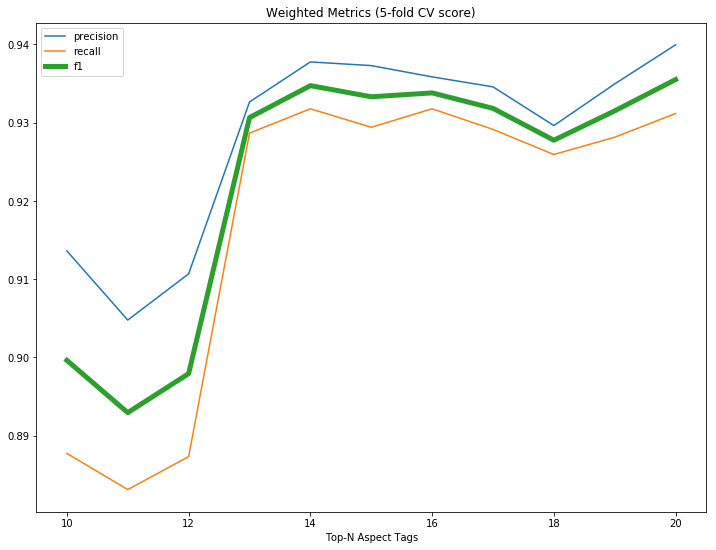

In [85]:
plt.figure(figsize=(12,9))
x = np.arange(10,21)
plt.plot(x, flatten_scores(cv_scores["precision"]), label="precision")
plt.plot(x, flatten_scores(cv_scores["recall"]), label="recall")
plt.plot(x, flatten_scores(cv_scores["f1"]), label="f1", linewidth=5)
plt.legend()
plt.title("Weighted Metrics (5-fold CV score)")
plt.xlabel("Top-N Aspect Tags")
plt.show()

The weighted f1 scores actually look quite good, mostly in the .9x. Since this looks quite good let's check it on the test data for a final evaluation.

In [46]:
aspect_train, aspect_test = dm.get_aspect_terms()
X_train, y_train, X_test, y_test = dm.get_data_for_crf()

test_scores = {
    "precision": [],
    "recall": [],
    "f1": []
}

ate = AspectTermExtractor("crf_baseline.model", c2=0.011, possible_transitions=True)
ate.fit(X_train, y_train)

for n in range(10,21):
    scores = ate.evaluate(X_test, aspect_test, n=n)
    test_scores["precision"].append(scores["precision"])
    test_scores["recall"].append(scores["recall"])
    test_scores["f1"].append(scores["f1"])

print(test_scores)        

{'precision': [0.8425687576209185, 0.8172044295253909, 0.8245544692575068, 0.8550026047279521, 0.8923594368341593, 0.8945220475397593, 0.9075643150853314, 0.8920430704379312, 0.8778638384230981, 0.9353079182536552, 0.9396813875946273], 'recall': [0.7866142799078716, 0.7629343813835696, 0.7693005196405529, 0.8141873466940898, 0.9207840011333641, 0.9296813650265062, 0.930981355263714, 0.9150596303379629, 0.9005145447519053, 0.9019904356283572, 0.9033525348032799], 'f1': [0.8136306372968072, 0.7891374499500073, 0.7959697539489409, 0.8340959656112562, 0.9063489137057343, 0.9117628795937356, 0.9191237070403784, 0.9034047726562541, 0.8890449437429351, 0.9183470881033001, 0.9211589141958312]}


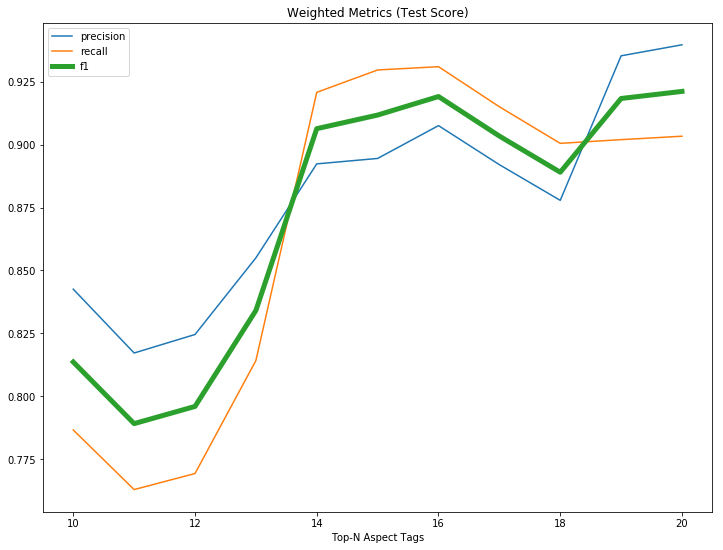

In [47]:
plt.figure(figsize=(12,9))
x = np.arange(10,21)
plt.plot(x, test_scores["precision"], label="precision")
plt.plot(x, test_scores["recall"], label="recall")
plt.plot(x, test_scores["f1"], label="f1", linewidth=5)
plt.legend()
plt.title("Weighted Metrics (Test Score)")
plt.xlabel("Top-N Aspect Tags")
plt.show()

# Output for user
Now that we have a aspect term extractor, the top-n terms can be extracted for the user.

In [48]:
ate = AspectTermExtractor("crf_baseline.model", c2=0.011, possible_transitions=True)
ate.fit(X_train, y_train)
top_aspect_terms = ate.get_top_n(X_test, 15)

In [49]:
top_aspect_terms

['price',
 'performance',
 'features',
 'windows',
 'os',
 'screen',
 'keyboard',
 'size',
 'battery',
 'runs',
 'battery life',
 'speed',
 'use',
 'works',
 'set up']

In [50]:
from wordcloud import WordCloud

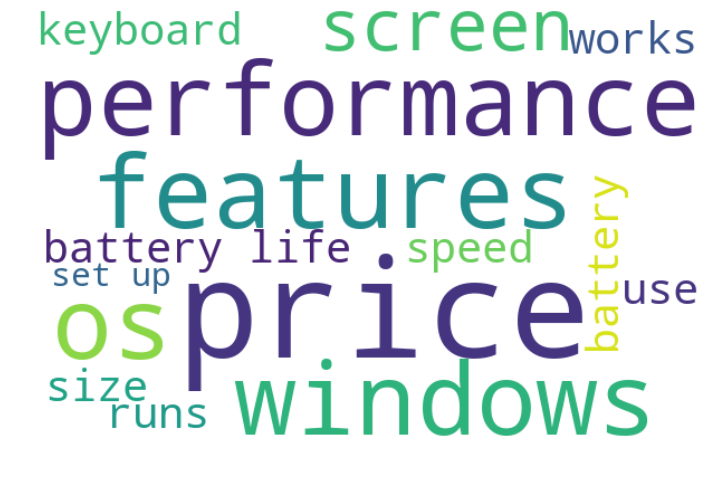

In [51]:
words = {x:1 for x in top_aspect_terms}
wordcloud = WordCloud(background_color="white", relative_scaling=0, width=600, height=400).generate_from_frequencies(words)
plt.figure(figsize=(12,9))
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")